In [51]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from skimage.draw import line_aa
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [52]:
# Create the train data


# Create Gaussian blurs with varying widths and occluding bars
def create_Gaussian_blurs(nGauss=1000, imgSize=91):
    """
    Create a set of random occluding bars.
    Returns:
        images (torch.Tensor): Tensor containing the generated images.
    """
    # Create a grid of points
    # Initialize tensor containing Gaussian blur images
    images = torch.zeros(nGauss, 1, imgSize, imgSize)
    labels = torch.zeros(nGauss, 1)
    classes = ["Horiz.", "Vert."]
    for i in range(nGauss):
        # Create Gaussian blur
        G = np.random.randn(imgSize, imgSize) / 2

        # Add random bar randomly
        i1 = np.random.choice(np.arange(2, 28))
        i2 = np.random.choice(np.arange(2, 6))

        if np.random.randn() > 0:
            G[i1 : (i1 + i2*3),] = 1
            labels[i] = 0
        else:
            G[:, i1 : (i1 + i2*3)] = 1
            labels[i] = 1

        # Add to the tensor images
        images[i, :, :, :] = torch.tensor(G).view(1, imgSize, imgSize)
    return images, labels, classes


# Create Gaussian blur images
imgSize = 91
nGauss_train = 20000
nGauss_dev = 1000
train_images, train_labels, classes = create_Gaussian_blurs(nGauss_train, imgSize)
dev_images, dev_labels, classes = create_Gaussian_blurs(nGauss_dev, imgSize)

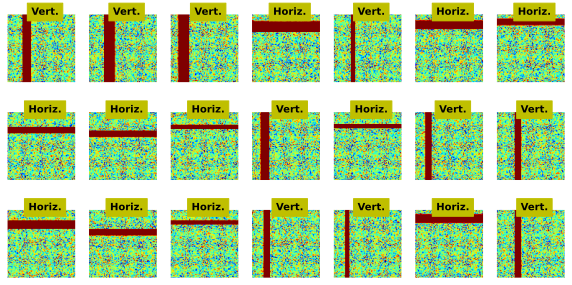

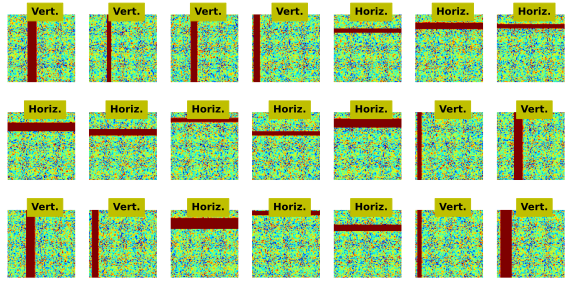

In [53]:
# visualize some train images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_train)
    label = train_labels[whichpic]
    im_class = classes[int(label[0])]
    G = np.squeeze(train_images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=im_class)
    ax.text(
        50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# visualize some dev images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_dev)
    label = dev_labels[whichpic]
    im_class = classes[int(label[0])]
    G = np.squeeze(dev_images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=im_class)
    ax.text(
        50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [54]:
# Test data initialization
# Create the train data


# Create Gaussian blurs with varying widths and occluding bars
def create_test_images(nGauss=1000, imgSize=91):
    """
    Create a set of random occluding bars.
    Returns:
        images (torch.Tensor): Tensor containing the generated images.
    """
    # Create a grid of points
    # Initialize tensor containing Gaussian blur images
    images = torch.zeros(nGauss, 1, imgSize, imgSize)
    for i in range(nGauss):
        # Create Gaussian blur
        # Add random bar randomly
        image = torch.zeros((91, 91))
        r0 = np.random.choice(np.arange(0, 91))
        c0 = np.random.choice(np.arange(0, 91))
        r1 = np.random.choice(np.arange(0, 91))
        c1 = np.random.choice(np.arange(0, 91))
        rr, cc, val = line_aa(0, c0, r1, 90)
        image[rr, cc] = torch.tensor(val * 255).float()
        image = image.reshape((1, 91, 91))
        images[i] = image
    return images


# Create Gaussian blur images
imgSize = 91
nGauss_test = 100
test_images = create_test_images(nGauss_test, imgSize).to(device)
print(test_images.shape)

torch.Size([100, 1, 91, 91])


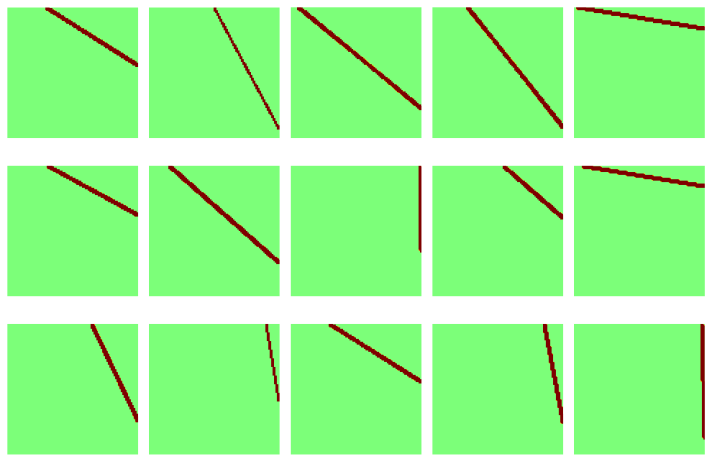

In [56]:
# visualize some test images
fig, axs = plt.subplots(3, 5, figsize=(10, 7))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_test)
    G = np.squeeze(test_images[whichpic])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [57]:
print(dev_images.shape,dev_labels.shape, train_images.shape, train_labels.shape)

torch.Size([1000, 1, 91, 91]) torch.Size([1000, 1]) torch.Size([20000, 1, 91, 91]) torch.Size([20000, 1])


In [58]:
# Data normalization
train_images = train_images / torch.max(train_images)
def_images = dev_images / torch.max(dev_images)
test_images = test_images / torch.max(test_images)
# Pytorch Dataset
train_datasets = TensorDataset(train_images, train_labels)
dev_datasets = TensorDataset(dev_images, dev_labels)

# Data loaders
batchSize = 32
train_loader = DataLoader(train_datasets, batch_size=batchSize, shuffle=True, drop_last=True, generator=torch.Generator(device=device) )
dev_loader = DataLoader(dev_datasets, batch_size=dev_datasets.tensors[0].shape[0], generator=torch.Generator(device=device) )

In [92]:
# Create model function
def createPsychometicNet(print_toggle=False):
    class psychometicNet(nn.Module):
        def __init__(self, print_toggle):

            super().__init__()
            self.print = print_toggle

            # Convolution Layer
            self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # => ((91 +2 - 3) / 1 ) / 2 => 45
            self.bn1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 128, 3, padding=1) # => (45 + 2 -3) / 2 => 22
            self.bn2 = nn.BatchNorm2d(128)
            self.conv3 = nn.Conv2d(128, 256, 4, padding=1) # => (22 + 2 - 4) / 2 = 10
            self.bn3 = nn.BatchNorm2d(256)
            self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1) # => ((10 + 2 - 4) / 2 ) / 2 = 2
            self.bn4 = nn.BatchNorm2d(512)

            # FC Layers
            self.fc1 = nn.Linear(2 * 2 * 512, 128)
            self.fc2 = nn.Linear(128, 32)
            self.out = nn.Linear(32, 1)

        def forward(self, x):
            if self.print:
                print(f"Input: {list(x.shape)}")

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv1(x)
            x = F.max_pool2d(x, 2)
            x = self.bn1(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.bn2(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # third block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv3(x)
            x = F.max_pool2d(x, 2)
            x = self.bn3(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # forth block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv4(x)
            x = F.max_pool2d(x, 2)
            x = self.bn4(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            x = F.relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.relu(self.fc2(x))
            x = F.sigmoid(self.out(x))
            if self.print:
                print(f"Final output: {list(x.shape)}")

            return x

    # Inistantiate the model
    net = psychometicNet(print_toggle=print_toggle)

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [93]:
net, lossFun, optimizer = createPsychometicNet(True)
X, y = next(iter(train_loader))
yHat = net(X)

# Check the output size
print(y.shape, yHat.shape)
print(f"Output size: {yHat.reshape(yHat.shape[0]).shape}\n")

# Loss Function
loss = lossFun(yHat, y)
print(f"Loss: {loss}")
print(yHat)

Input: [32, 1, 91, 91]
First CPR block: [32, 16, 45, 45]
First CPR block: [32, 128, 22, 22]
First CPR block: [32, 256, 10, 10]
First CPR block: [32, 512, 2, 2]
Vectorized: [32, 2048]
Final output: [32, 1]
torch.Size([32, 1]) torch.Size([32, 1])
Output size: torch.Size([32])

Loss: 0.2386794090270996
tensor([[0.5421],
        [0.6200],
        [0.5378],
        [0.5359],
        [0.5191],
        [0.5704],
        [0.5386],
        [0.5664],
        [0.5512],
        [0.5163],
        [0.5405],
        [0.5678],
        [0.5736],
        [0.5209],
        [0.5833],
        [0.5328],
        [0.5471],
        [0.5868],
        [0.5419],
        [0.5918],
        [0.5222],
        [0.5264],
        [0.5353],
        [0.5360],
        [0.5794],
        [0.5751],
        [0.5317],
        [0.5566],
        [0.5537],
        [0.5486],
        [0.5415],
        [0.5465]], device='cuda:0', grad_fn=<SigmoidBackward0>)
